In [1]:
# Home Credit Default Risk

import os
import pandas as pd
import numpy as np
import gc
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

HOME_CREDIT_PATH = os.path.join("datasets", "HomeCredit")

def load_home_credit_data(filename, home_credit_path=HOME_CREDIT_PATH):
    csv_path = os.path.join(home_credit_path, filename)
    return pd.read_csv(csv_path)

def load_bureau_data(home_credit_path=HOME_CREDIT_PATH):
    # read_csv
    bureau = pd.read_csv(os.path.join(home_credit_path, "bureau.csv"))
    bureau_balance = pd.read_csv(os.path.join(home_credit_path, "bureau_balance.csv"))
    
    # grouped
    bureau_agg = {'MONTHS_BALANCE': ['mean', 'size']}
    selected_bureau = bureau_balance.groupby('SK_ID_BUREAU').agg(bureau_agg).reset_index()
    selected_bureau['MONTHS_BALANCE_MEAN'] = selected_bureau.loc[:, ('MONTHS_BALANCE', 'mean')]
    selected_bureau['MONTHS_BALANCE_SIZE'] = selected_bureau.loc[:, ('MONTHS_BALANCE', 'size')]
    selected_bureau['BUREAU_BALANCE_CNT'] = bureau_balance.groupby('SK_ID_BUREAU').size().reset_index().iloc[:, 1]
    selected_bureau.drop(['MONTHS_BALANCE'], axis=1, inplace=True)

    # merge
    merged_bureau = bureau.merge(selected_bureau,
                    on='SK_ID_BUREAU', how='left')
    merged_bureau = merged_bureau.groupby('SK_ID_CURR').mean().reset_index()
    merged_bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bureau, bureau_balance, selected_bureau
    gc.collect()
    return merged_bureau

def load_pos_cash_data(home_credit_path=HOME_CREDIT_PATH):
    # read_csv
    pos_cash = pd.read_csv(os.path.join(home_credit_path, "POS_CASH_balance.csv"))
    
    # grouped
    pos_cash_num_agg = {
        'MONTHS_BALANCE': ['size', 'mean'],
        'CNT_INSTALMENT': ['mean', 'min', 'max'],
        'CNT_INSTALMENT_FUTURE': ['mean', 'min', 'max'],
        'SK_DPD': ['mean'],
        'SK_DPD_DEF': ['mean'],
    }
    grouped_pos = pos_cash.groupby('SK_ID_CURR').agg(pos_cash_num_agg).reset_index()
    cols = grouped_pos.columns.tolist()
    del cols[0] # SK_ID_CURRを除外
    for col in cols:
        grouped_pos['POS_' + col[0] + "_" + col[1].upper()] = grouped_pos.loc[:, (col[0], col[1])]
    grouped_pos['POS_BALANCE_CNT'] = pos_cash.groupby('SK_ID_CURR').size().reset_index().iloc[:, 1]
    grouped_pos.drop(columns=cols, axis=1, inplace=True)
    del pos_cash
    gc.collect()
    return grouped_pos

def load_installments_payments_data(home_credit_path=HOME_CREDIT_PATH):
    # read_csv
    payment = pd.read_csv(os.path.join(home_credit_path, "installments_payments.csv"))
    
    # grouped
    payment_num_agg = {
        'NUM_INSTALMENT_VERSION': ['mean'],
        'NUM_INSTALMENT_NUMBER': ['mean'],
        'AMT_INSTALMENT': ['mean', 'min', 'max'],
        'AMT_PAYMENT': ['mean', 'min', 'max'],
    }
    grouped_payment = payment.groupby('SK_ID_CURR').agg(payment_num_agg).reset_index()
    cols = grouped_payment.columns.tolist()
    del cols[0] # SK_ID_CURRを除外
    for col in cols:
        grouped_payment['PAY_' + col[0] + "_" + col[1].upper()] = grouped_payment.loc[:, (col[0], col[1])]
    grouped_payment['PAY_BALANCE_CNT'] = payment.groupby('SK_ID_CURR').size().reset_index().iloc[:, 1]
    grouped_payment.drop(columns=cols, axis=1, inplace=True)
    del payment
    gc.collect()
    return grouped_payment

def load_credit_card_balance_data(home_credit_path=HOME_CREDIT_PATH):
    # read_csv
    credit = pd.read_csv(os.path.join(home_credit_path, "credit_card_balance.csv"))
    
    # grouped
    credit_num_agg = {
        'MONTHS_BALANCE': ['mean', 'min', 'max'],
        'AMT_BALANCE': ['mean', 'min', 'max'],
        'AMT_CREDIT_LIMIT_ACTUAL': ['mean'],
        'AMT_DRAWINGS_ATM_CURRENT': ['mean', 'min', 'max'],
        'AMT_DRAWINGS_OTHER_CURRENT': ['mean', 'min', 'max'],
        'CNT_DRAWINGS_POS_CURRENT': ['mean', 'min', 'max'],
        'CNT_INSTALMENT_MATURE_CUM': ['mean']
    }
    grouped_credit = credit.groupby('SK_ID_CURR').agg(credit_num_agg).reset_index()
    cols = grouped_credit.columns.tolist()
    del cols[0] # SK_ID_CURRを除外
    for col in cols:
        grouped_credit['CC_' + col[0] + "_" + col[1].upper()] = grouped_credit.loc[:, (col[0], col[1])]
    grouped_credit['CC_BALANCE_CNT'] = credit.groupby('SK_ID_CURR').size().reset_index().iloc[:, 1]
    grouped_credit.drop(columns=cols, axis=1, inplace=True)
    del credit
    gc.collect()
    return grouped_credit

def load_prev_application_data(home_credit_path=HOME_CREDIT_PATH):
    # read_csv
    prev_app = pd.read_csv(os.path.join(home_credit_path, "previous_application.csv"))
    
    # describe
    prev_app.describe()
    
    # 特徴量の追加
    prev_app['PREV_CREDIT_ANNUITY_PERCENT'] = prev_app['AMT_CREDIT'] / prev_app['AMT_ANNUITY']
    prev_app['PREV_APP_ANNUITY_PERCENT'] = prev_app['AMT_APPLICATION'] / prev_app['AMT_ANNUITY']
    prev_app.drop(['SK_ID_PREV'], axis=1, inplace=True)
    
    # labelEncoder
    le = LabelEncoder()

    # ラベルエンコーディング
    for col in prev_app.columns:
        if prev_app[col].dtype == 'object':
            if len(list(prev_app[col].unique())) <= 2:
                le.fit_transform(prev_app[col])
                print(col)
            
    grouped_prev_app = prev_app.groupby('SK_ID_CURR').mean().reset_index()
    del prev_app, le
    gc.collect()
    return grouped_prev_app

In [2]:
print(load_prev_application_data())

FLAG_LAST_APPL_PER_CONTRACT
        SK_ID_CURR   AMT_ANNUITY  AMT_APPLICATION     AMT_CREDIT  \
0           100001   3951.000000     24835.500000   23787.000000   
1           100002   9251.775000    179055.000000  179055.000000   
2           100003  56553.990000    435436.500000  484191.000000   
3           100004   5357.250000     24282.000000   20106.000000   
4           100005   4813.200000     22308.750000   20076.750000   
5           100006  23651.175000    272203.260000  291695.500000   
6           100007  12278.805000    150530.250000  166638.750000   
7           100008  15839.696250    155701.800000  162767.700000   
8           100009  10051.412143     76741.714286   70137.642857   
9           100010  27463.410000    247212.000000  260811.000000   
10          100011  18303.195000    202732.875000  261840.375000   
11          100012   7894.155000     60930.000000   74119.500000   
12          100013  11478.195000    130871.250000  146134.125000   
13          100014  

In [3]:
# train

app_train = load_home_credit_data("application_train.csv")
app_train.shape

(307511, 122)

In [4]:
# test

app_test = load_home_credit_data("application_test.csv")
app_test.shape

(48744, 121)

In [5]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
app_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [7]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [8]:
app_train.isnull().sum()

SK_ID_CURR                         0
TARGET                             0
NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                       12
AMT_GOODS_PRICE                  278
NAME_TYPE_SUITE                 1292
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
REGION_POPULATION_RELATIVE         0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
OWN_CAR_AGE                   202929
FLAG_MOBIL                         0
FLAG_EMP_PHONE                     0
FLAG_WORK_PHONE                    0
FLAG_CONT_MOBILE                   0
FLAG_PHONE                         0
F

In [9]:
app_test.isnull().sum()

SK_ID_CURR                        0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
FLAG_OWN_REALTY                   0
CNT_CHILDREN                      0
AMT_INCOME_TOTAL                  0
AMT_CREDIT                        0
AMT_ANNUITY                      24
AMT_GOODS_PRICE                   0
NAME_TYPE_SUITE                 911
NAME_INCOME_TYPE                  0
NAME_EDUCATION_TYPE               0
NAME_FAMILY_STATUS                0
NAME_HOUSING_TYPE                 0
REGION_POPULATION_RELATIVE        0
DAYS_BIRTH                        0
DAYS_EMPLOYED                     0
DAYS_REGISTRATION                 0
DAYS_ID_PUBLISH                   0
OWN_CAR_AGE                   32312
FLAG_MOBIL                        0
FLAG_EMP_PHONE                    0
FLAG_WORK_PHONE                   0
FLAG_CONT_MOBILE                  0
FLAG_PHONE                        0
FLAG_EMAIL                        0
OCCUPATION_TYPE             

In [10]:
# Number of unique classes
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [11]:
# Correlation

correlations = app_train.corr()['TARGET'].sort_values()

print('Positive Correlations:\n', correlations.tail(20))
print('\nNegative Correlations:\n', correlations.head(20))

Positive Correlations:
 OBS_30_CNT_SOCIAL_CIRCLE       0.009131
CNT_FAM_MEMBERS                0.009308
CNT_CHILDREN                   0.019187
AMT_REQ_CREDIT_BUREAU_YEAR     0.019930
FLAG_WORK_PHONE                0.028524
DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_

In [12]:
# EDA

import matplotlib.pyplot as plt
import seaborn as sns

# Targetの数をプロット
sns.countplot(app_train['TARGET'])

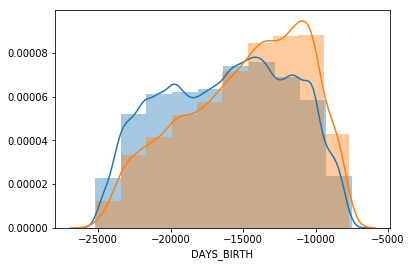

In [13]:
# DAYS_BIRTH
sns.distplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'], kde=True, rug=False, bins=10) 
sns.distplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'], kde=True, rug=False, bins=10) 

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


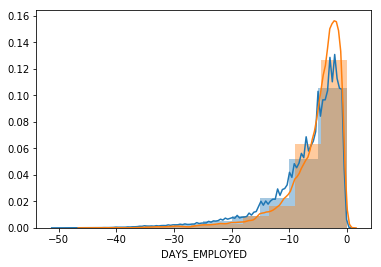

In [14]:
# DAYS_EMPLOYED
app_train.loc[app_train['DAYS_EMPLOYED'] > 50000, 'DAYS_EMPLOYED']= np.nan
app_test.loc[app_test['DAYS_EMPLOYED'] > 50000, 'DAYS_EMPLOYED']= np.nan

sns.distplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_EMPLOYED'] // 365 , kde=True, rug=False, bins=10) 
sns.distplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_EMPLOYED'] // 365 , kde=True, rug=False, bins=10) 

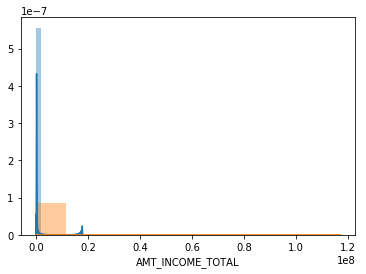

In [15]:
# AMT_INCOME_TOTAL

sns.distplot(app_train.loc[app_train['TARGET'] == 0, 'AMT_INCOME_TOTAL'], kde=True, rug=False, bins=10) 
sns.distplot(app_train.loc[app_train['TARGET'] == 1, 'AMT_INCOME_TOTAL'], kde=True, rug=False, bins=10) 

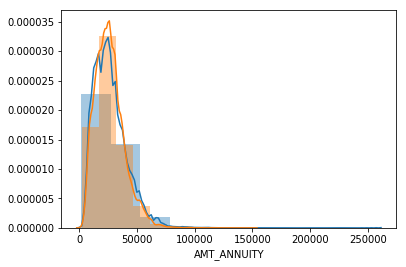

In [16]:
# AMT_ANNUITY

sns.distplot(app_train.loc[app_train['TARGET'] == 0, 'AMT_ANNUITY'], kde=True, rug=False, bins=10) 
sns.distplot(app_train.loc[app_train['TARGET'] == 1, 'AMT_ANNUITY'], kde=True, rug=False, bins=10) 

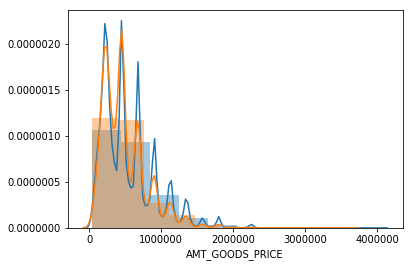

In [17]:
# AMT_GOODS_PRICE
    
sns.distplot(app_train.loc[app_train['TARGET'] == 0, 'AMT_GOODS_PRICE'], kde=True, rug=False, bins=10) 
sns.distplot(app_train.loc[app_train['TARGET'] == 1, 'AMT_GOODS_PRICE'], kde=True, rug=False, bins=10) 

In [18]:
# AMT_GOODS_PRICE
app_train['AMT_GOODS_PRICE'].describe()

count    3.072330e+05
mean     5.383962e+05
std      3.694465e+05
min      4.050000e+04
25%      2.385000e+05
50%      4.500000e+05
75%      6.795000e+05
max      4.050000e+06
Name: AMT_GOODS_PRICE, dtype: float64

In [19]:
# 前処理用に訓練データとテストデータを結合

df_app = app_train.append(app_test).reset_index()

df_app = df_app[df_app['CODE_GENDER'] != 'XNA']

df_app.shape

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


(356251, 123)

In [20]:
# テーブルの結合

# bureau
df_app = df_app.merge(load_bureau_data(), on='SK_ID_CURR', how='left', suffixes=['', '_BUR'])

# previous_application
df_app = df_app.merge(load_prev_application_data(), on='SK_ID_CURR', how='left', suffixes=['', '_PREV'])

#POS_CASH_balance
df_app = df_app.merge(load_pos_cash_data(), on='SK_ID_CURR', how='left', suffixes=['', '_POS'])

#installments_payments_balance
df_app = df_app.merge(load_installments_payments_data(), on='SK_ID_CURR', how='left', suffixes=['', '_INS'])

#credit_card_balance
df_app = df_app.merge(load_credit_card_balance_data(), on='SK_ID_CURR', how='left', suffixes=['', '_CC'])
df_app.shape

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


FLAG_LAST_APPL_PER_CONTRACT


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


(356251, 197)

In [21]:
df_app.describe()

,index,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,...,"(CC_AMT_DRAWINGS_ATM_CURRENT_MIN, )","(CC_AMT_DRAWINGS_ATM_CURRENT_MAX, )","(CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN, )","(CC_AMT_DRAWINGS_OTHER_CURRENT_MIN, )","(CC_AMT_DRAWINGS_OTHER_CURRENT_MAX, )","(CC_CNT_DRAWINGS_POS_CURRENT_MEAN, )","(CC_CNT_DRAWINGS_POS_CURRENT_MIN, )","(CC_CNT_DRAWINGS_POS_CURRENT_MAX, )","(CC_CNT_INSTALMENT_MATURE_CUM_MEAN, )","(CC_BALANCE_CNT, )"
count,356251.000000,356215.000000,3.562510e+05,3.559730e+05,3.562510e+05,308683.000000,308683.000000,308683.000000,308683.000000,308683.000000,...,72194.000000,7.219400e+04,72194.000000,72194.000000,7.219400e+04,72194.000000,72194.000000,72194.000000,103558.000000,103558.000000
mean,136052.869904,27425.644390,5.877695e+05,5.280212e+05,1.701159e+05,0.006282,0.005809,0.231691,0.304400,0.029995,...,610.728574,1.048650e+05,583.772133,5.086295,9.531028e+03,1.760667,0.165637,6.500277,10.066951,37.083683
std,93841.582375,14732.860946,3.986253e+05,3.660657e+05,2.235080e+05,0.104251,0.079737,0.855940,0.786919,0.191375,...,11176.381884,1.071061e+05,4518.785160,644.651543,4.890023e+04,4.282159,1.353768,11.755416,13.536168,33.483627
min,0.000000,1615.500000,4.500000e+04,4.050000e+04,2.565000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,...,-6827.310000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000
25%,44532.000000,16731.000000,2.700000e+05,2.340000e+05,1.125000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.700000e+04,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,10.000000
50%,129384.000000,25078.500000,5.002110e+05,4.500000e+05,1.530000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,9.000000e+04,0.000000,0.000000,0.000000e+00,0.052083,0.000000,1.000000,3.800000,22.000000
75%,218447.500000,34960.500000,7.975575e+05,6.750000e+05,2.025000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.372500e+05,0.000000,0.000000,0.000000e+00,1.468750,0.000000,8.000000,14.965517,75.000000
max,307510.000000,258025.500000,4.050000e+06,4.050000e+06,1.170000e+08,9.000000,4.000000,27.000000,261.000000,8.000000,...,904500.000000,2.115000e+06,225000.000000,112500.000000,1.529847e+06,118.250000,78.000000,165.000000,73.062500,192.000000


In [22]:
# Correlation

correlations = df_app[df_app['TARGET'].notnull()].corr()['TARGET'].sort_values()

print('Positive Correlations:\n', correlations.tail(20))
print('\nNegative Correlations:\n', correlations.head(20))

Positive Correlations:
 REG_CITY_NOT_WORK_CITY                  0.050992
DAYS_ID_PUBLISH                         0.051457
(CC_CNT_DRAWINGS_POS_CURRENT_MEAN, )    0.052547
DAYS_ENDDATE_FACT                       0.053203
DAYS_LAST_PHONE_CHANGE                  0.055219
REGION_RATING_CLIENT                    0.058901
(CC_AMT_DRAWINGS_ATM_CURRENT_MEAN, )    0.059925
REGION_RATING_CLIENT_W_CITY             0.060895
(CC_MONTHS_BALANCE_MIN, )               0.061359
(CC_MONTHS_BALANCE_MEAN, )              0.062081
(CC_AMT_BALANCE_MIN, )                  0.064163
(CC_AMT_BALANCE_MAX, )                  0.068798
DAYS_CREDIT_UPDATE                      0.068929
(CC_CNT_DRAWINGS_POS_CURRENT_MAX, )     0.068942
DAYS_EMPLOYED                           0.074957
(MONTHS_BALANCE_MEAN, )                 0.076424
DAYS_BIRTH                              0.078242
(CC_AMT_BALANCE_MEAN, )                 0.087177
DAYS_CREDIT                             0.089731
TARGET                                  1.000

In [23]:
# 不要なレコードを削除

df_app = df_app[df_app['CODE_GENDER'] != 'XNA']

In [24]:
# 特徴同士の組み合わせによる特徴量の作成
df_app['ANNUITY_INCOME_PERCENT'] = df_app['AMT_ANNUITY'] / df_app['AMT_INCOME_TOTAL']
df_app['CREDIT_INCOME_PERCENT'] = df_app['AMT_CREDIT'] / df_app['AMT_INCOME_TOTAL']
df_app['CREDIT_ANNUITY_PERCENT'] = df_app['AMT_CREDIT'] / df_app['AMT_ANNUITY']
df_app['ANNUITY_PRICE_PERCENT'] = df_app['AMT_ANNUITY'] / df_app['AMT_GOODS_PRICE']
df_app['EMPLOYED_BIRTH_RATIO'] = df_app['DAYS_EMPLOYED'] / df_app['DAYS_BIRTH']
df_app['CREDIT_BIRTH_RATIO'] = df_app['DAYS_CREDIT'] / df_app['DAYS_BIRTH']
df_app['PUBLISH_BIRTH_RATIO'] = df_app['DAYS_ID_PUBLISH'] / df_app['DAYS_BIRTH']
df_app['AMT_CREDIT_DEBT_PERCENT'] = np.log1p(df_app['AMT_CREDIT_SUM'] / df_app['AMT_CREDIT_SUM_DEBT'].replace(0, np.nan))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log1p
  if __name__ == '__main__':


In [25]:
# clipping

num_cols = df_app[df_app.columns[df_app.columns != 'index']].select_dtypes(include='number').columns.tolist()
print(num_cols)

p01 = df_app[num_cols].quantile(0.01)
p99 = df_app[num_cols].quantile(0.99)

# 各列の置換
df_app[num_cols] = df_app[num_cols].clip(p01, p99, axis=1)

['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'APARTMENTS_AVG', 'APARTMENTS_MEDI', 'APARTMENTS_MODE', 'BASEMENTAREA_AVG', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_MODE', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'COMMONAREA_AVG', 'COMMONAREA_MEDI', 'COMMONAREA_MODE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'ELEVATORS_AVG', 'ELEVATORS_MEDI', 'ELEVATORS_MODE', 'ENTRANCES_AVG', 'ENTRANCES_MEDI', 'ENTRANCES_MODE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'FLAG_CONT_MOBILE', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_2',

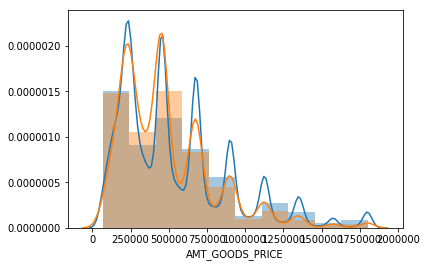

In [26]:
app_train = df_app[df_app['TARGET'].notnull()]

sns.distplot(app_train.loc[app_train['TARGET'] == 0, 'AMT_GOODS_PRICE'], kde=True, rug=False, bins=10) 
sns.distplot(app_train.loc[app_train['TARGET'] == 1, 'AMT_GOODS_PRICE'], kde=True, rug=False, bins=10) 

In [27]:
#targer encoding

# 再度訓練データとテストデータに分割
app_train = df_app[df_app['TARGET'].notnull()]
app_test = df_app[df_app['TARGET'].isnull()]
train_label = app_train['TARGET']

# カテゴリ列
cat_cols = ['REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'REG_CITY_NOT_LIVE_CITY', 'FLAG_EMP_PHONE']

# target encoding
for c in cat_cols:
    # 訓練データで各カテゴリにおける平均を計算
    df_tmp = pd.DataFrame({c: app_train[c], 'target': train_label})
    target_mean = df_tmp.groupby(c)['target'].mean()
    # テストデータのカテゴリを置換
    app_test[c] = app_test[c].map(target_mean)

    # 訓練データの値を格納する配列
    tmp = np.repeat(np.nan, app_train.shape[0])

    # 訓練データを分割
    kf = KFold(n_splits=4, shuffle=True, random_state=72)
    for idx_tr, idx_va in kf.split(app_train):
        # out-of-foldで各カテゴリにおける目的変数の平均を計算
        target_mean = df_tmp.iloc[idx_tr].groupby(c)['target'].mean()
        # 変換後の値を一時配列に格納
        tmp[idx_va] = app_train[c].iloc[idx_va].map(target_mean)

    # 変換後のデータで元の変数を置換
    app_train[c] = tmp
    
# 訓練データとテストデータを再結合
df_app = app_train.append(app_test).reset_index()
print(df_app[cat_cols])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


        REGION_RATING_CLIENT_W_CITY  REGION_RATING_CLIENT  \
0                          0.079361              0.079108   
1                          0.048463              0.048474   
2                          0.079361              0.079108   
3                          0.079474              0.079184   
4                          0.079416              0.079064   
5                          0.078465              0.078214   
6                          0.079416              0.079064   
7                          0.113782              0.110842   
8                          0.078465              0.078214   
9                          0.079361              0.079108   
10                         0.078465              0.078214   
11                         0.078465              0.078214   
12                         0.079416              0.079064   
13                         0.079361              0.079108   
14                         0.047561              0.078214   
15                      

In [28]:
# labelEncoder
le = LabelEncoder()

# ラベルエンコーディング
for col in df_app.columns:
    if df_app[col].dtype == 'object':
        if len(list(df_app[col].unique())) <= 2:
            le.fit_transform(df_app[col])
            print(col)

CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_CONTRACT_TYPE


In [29]:
# ワンホットエンコーディング
one_hot_cols = list(df_app.select_dtypes(include='object').columns)

print(df_app.shape)

df_app = pd.get_dummies(df_app, columns=one_hot_cols)

print(df_app.shape)

(356251, 206)
(356251, 329)


In [30]:
# DAYS_EMPLOYEDの外れ値を変換

df_app[df_app['DAYS_EMPLOYED'] > 50000]['DAYS_EMPLOYED'] = np.nan

In [31]:
# 訓練データとテストデータに分割
app_train = df_app[df_app['TARGET'].notnull()]
app_test = df_app[df_app['TARGET'].isnull()]
print(app_train.shape)
print(app_test.shape)

# 特徴量と目的変数に分離
train_label = app_train['TARGET']
app_train.drop(['TARGET'], axis=1, inplace=True)
test_X = app_test.copy()

(307507, 329)
(48744, 329)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [32]:
# 不要な特徴量をドロップ
app_train.drop(['SK_ID_CURR'], axis=1, inplace=True)
test_X.drop(['SK_ID_CURR'], axis=1, inplace=True)

In [33]:
# 学習データを4分割し、学習・評価を行う

# 結果を格納する変数の初期化
oof_preds = np.zeros(app_train.shape[0])
sub_preds = np.zeros(test_X.shape[0])

kf = KFold(n_splits=4, shuffle=True, random_state=71)

for tr_idx, va_idx in kf.split(app_train):
    
    # trainとvalidに分割
    train_X, valid_X = app_train.iloc[tr_idx], app_train.iloc[va_idx]
    train_y, valid_y = train_label.iloc[tr_idx], train_label.iloc[va_idx]
    
    # データセットの生成
    clf = LGBMClassifier(
        nthread=4,
        n_estimators=10000,
        learning_rate=0.1,
        num_leaves=34,
        colsample_bytree=0.9497036,
        subsample=0.8715623,
        max_depth=8,
        reg_alpha=0.041545473,
        reg_lambda=0.0735294,
        min_split_gain=0.0222415,
        min_child_weight=39.3259775,
        silent=-1,
        verbose=-1, )
    
    clf.fit(train_X, train_y, eval_metric= 'auc',
               eval_set=[(train_X, train_y), (valid_X, valid_y)], verbose=100,
               early_stopping_rounds=50)

    # 結果の格納
    oof_preds[va_idx] = clf.predict_proba(valid_X, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_X[test_X.columns[test_X.columns != 'index']], num_iteration=clf.best_iteration_)[:, 1] / kf.n_splits

Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.823139	training's binary_logloss: 0.224313	valid_1's auc: 0.781149	valid_1's binary_logloss: 0.239227
[200]	training's auc: 0.854791	training's binary_logloss: 0.211742	valid_1's auc: 0.782876	valid_1's binary_logloss: 0.238429
Early stopping, best iteration is:
[177]	training's auc: 0.848605	training's binary_logloss: 0.214294	valid_1's auc: 0.783185	valid_1's binary_logloss: 0.238366
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.824847	training's binary_logloss: 0.223457	valid_1's auc: 0.775032	valid_1's binary_logloss: 0.241813
[200]	training's auc: 0.855379	training's binary_logloss: 0.210984	valid_1's auc: 0.777371	valid_1's binary_logloss: 0.241244
Early stopping, best iteration is:
[229]	training's auc: 0.86273	training's binary_logloss: 0.207792	valid_1's auc: 0.777884	valid_1's binary_logloss: 0.241144
Training until validation scores don't improve for 50

In [34]:
# 平均スコアを出力
print(f'AUC: {roc_auc_score(train_label, oof_preds):.4f}')

AUC: 0.7824


In [35]:
# 特徴量寄与度

importance = pd.DataFrame(clf.feature_importances_, index=app_train.columns, columns=['importance']).sort_values(by="importance", ascending=False)
print(importance)

                                          importance
CREDIT_ANNUITY_PERCENT                           229
EXT_SOURCE_3                                     214
EXT_SOURCE_1                                     202
EXT_SOURCE_2                                     163
ANNUITY_PRICE_PERCENT                            142
DAYS_BIRTH                                       140
AMT_CREDIT_DEBT_PERCENT                          130
(PAY_AMT_PAYMENT_MIN, )                          125
AMT_ANNUITY                                      117
DAYS_EMPLOYED                                    113
AMT_CREDIT_SUM                                   107
(POS_CNT_INSTALMENT_FUTURE_MEAN, )               100
(PAY_NUM_INSTALMENT_NUMBER_MEAN, )                97
(POS_MONTHS_BALANCE_SIZE, )                       91
DAYS_CREDIT_ENDDATE                               88
AMT_CREDIT_MAX_OVERDUE                            87
ANNUITY_INCOME_PERCENT                            85
CNT_PAYMENT                                   

In [36]:
print(sub_preds)

[0.03593889 0.05159878 0.02685069 ... 0.01005223 0.01485002 0.0498762 ]


In [37]:
# datasetsディレクトリに結果を出力

result_out = load_home_credit_data("application_test.csv")
result_out["TARGET"] = sub_preds 
print(result_out[["SK_ID_CURR","TARGET"]])

submission_path = os.path.join(HOME_CREDIT_PATH, "home_credit_submission.csv")
result_out[["SK_ID_CURR","TARGET"]].to_csv(submission_path,index=False)

       SK_ID_CURR    TARGET
0          100001  0.035939
1          100005  0.051599
2          100013  0.026851
3          100028  0.011501
4          100038  0.051451
5          100042  0.039889
6          100057  0.010631
7          100065  0.023340
8          100066  0.014693
9          100067  0.020038
10         100074  0.029916
11         100090  0.013798
12         100091  0.031547
13         100092  0.041964
14         100106  0.013895
15         100107  0.046838
16         100109  0.035830
17         100117  0.013484
18         100128  0.056408
19         100141  0.039985
20         100150  0.016956
21         100168  0.011289
22         100169  0.036919
23         100170  0.030801
24         100171  0.018202
25         100172  0.033805
26         100184  0.030849
27         100187  0.022787
28         100212  0.014755
29         100222  0.032082
...           ...       ...
48714      455963  0.011009
48715      455965  0.009481
48716      456007  0.085110
48717      456008  0